In [1]:
import cv2 as cv
import matplotlib.pyplot as plt

img1 = cv.imread('data/01.jpg',cv.IMREAD_GRAYSCALE)
img2 = cv.imread('data/02.jpg',cv.IMREAD_GRAYSCALE)

### scale

In [2]:
scale_percent = 60 # percent of original size
width = int(img1.shape[1] * scale_percent / 100)
height = int(img1.shape[0] * scale_percent / 100)

dim = (width, height)
img1 = cv.resize(img1, dim, interpolation = cv.INTER_AREA)
img2 = cv.resize(img2, dim, interpolation = cv.INTER_AREA)

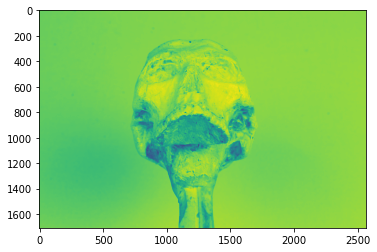

In [3]:
plt.imshow(img1)

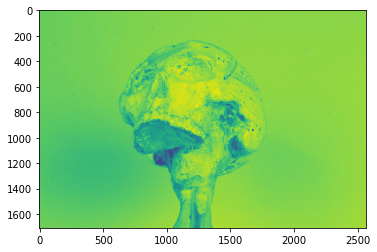

In [4]:
plt.imshow(img2)


Computing the disparity  map...


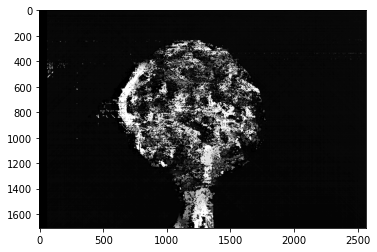

In [5]:
#Set disparity parameters
#Note: disparity range is tuned according to specific parameters obtained through trial and error.
win_size = 5
min_disp = -1
max_disp = 63 #min_disp * 9
num_disp = max_disp - min_disp # Needs to be divisible by 16
#Create Block matching object.
stereo = cv.StereoSGBM_create(minDisparity= min_disp,
 numDisparities = num_disp,
 blockSize = 5,
 uniquenessRatio = 5,
 speckleWindowSize = 5,
 speckleRange = 5,
 disp12MaxDiff = 1,
 P1 = 8*3*win_size**2,#8*3*win_size**2,
 P2 =32*3*win_size**2) #32*3*win_size**2)
#Compute disparity map
print ("\nComputing the disparity  map...")
disparity_map = stereo.compute(img1, img2)

#Show disparity map before generating 3D cloud to verify that point cloud will be usable.
plt.imshow(disparity_map,'gray')
plt.show()

In [15]:
import numpy as np


#Generate  point cloud.
print ("\nGenerating the 3D map...")
#Get new downsampled width and height
h,w = img2.shape[:2]
#Load focal length.
focal_length = 1
#Perspective transformation matrix
#This transformation matrix is from the openCV documentation, didn't seem to work for me.
Q = np.float32([[1,0,0,-w/2.0],
    [0,-1,0,h/2.0],
    [0,0,0,-focal_length],
    [0,0,1,0]])
#This transformation matrix is derived from Prof. Didier Stricker's power point presentation on computer vision.
#Link : https://ags.cs.uni-kl.de/fileadmin/inf_ags/3dcv-ws14-15/3DCV_lec01_camera.pdf
Q2 = np.float32([[1,0,0,0],
    [0,-1,0,0],
    [0,0,focal_length*0.05,0], #Focal length multiplication obtained experimentally.
    [0,0,0,1]])
#Reproject points into 3D
points_3D = cv.reprojectImageTo3D(disparity_map, Q2)
#Get color points
colors = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
#Get rid of points with value 0 (i.e no depth)
mask_map = disparity_map > disparity_map.min()
#Mask colors and points.
output_points = points_3D[mask_map]
output_colors = colors[mask_map]


Generating the 3D map...


In [16]:
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')


In [17]:
#Define name for output file
output_file = 'reconstructed.ply'
#Generate point cloud
print ("\n Creating the output file... \n")
create_output(output_points, output_colors, output_file)



 Creating the output file... 



In [18]:
output_points

array([[ 6.300e+01,  0.000e+00,  0.000e+00],
       [ 6.400e+01,  0.000e+00,  5.000e-02],
       [ 6.500e+01,  0.000e+00,  0.000e+00],
       ...,
       [ 2.559e+03, -1.707e+03,  0.000e+00],
       [ 2.560e+03, -1.707e+03,  5.000e-02],
       [ 2.561e+03, -1.707e+03,  5.000e-02]], dtype=float32)